In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import pickle
import pandas as pd

/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/weijiesun/anaconda3/envs/zd

In [2]:
with open('./source/annotation_data.pickle', 'rb') as handle:
    annotation_data = pickle.load(handle)

In [3]:
data = {
    'Y': [],
    'X': [],
    'domain': []
}
for list_item in annotation_data:
    data['domain'].append(list_item[0])
    data['Y'].append(list_item[1])
    l = list_item[2].values
    flat_list = [str(item) for sublist in l for item in sublist]
    columns = list(list_item[2].columns)
    columns = [str(item) for item in columns]
    data['X'].append(' '.join(flat_list) + ' '.join(columns))
    

In [4]:
dtf = pd.DataFrame.from_dict(data)

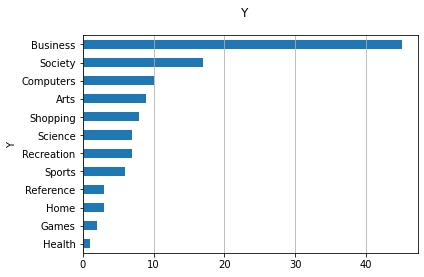

In [5]:
fig, ax = plt.subplots()
fig.suptitle("Y", fontsize=12)
dtf["Y"].reset_index().groupby("Y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [6]:
dtf = dtf[dtf['Y'].isin(['Business', 'Society', 'Computers', 'Arts', 'Shopping'])]
dtf

,Y,X,domain
0,Arts,Paintballs Valken Kilo Cal .50 4000 Und)*Envío...,www.tiendapaintball.com
1,Arts,1.0 BOTTLE O RING 2.0 PROTECCION CUELLO 3.0 SA...,www.tiendapaintball.com
2,Business,nan nan nan nan nan nan 1.0 2.0 3.0 4.0 5.0 6....,www.paragleiter.com
3,Computers,Timestamps (Monitoring Mode) No Yes Available ...,www.232analyzer.com
4,Computers,nan nan nan nan Programmable Buttons (1) Progr...,www.232analyzer.com
...,...,...,...
112,Society,65 and up $13 Under one year Free Group Rate $...,www.licm.org
114,Shopping,Liste des publications Publications sur Intern...,www.gboss.ca
115,Society,HeinOnline Lexis+* Lexis Digital Library (Stud...,library.law.hawaii.edu
116,Shopping,Currently Active Users: 96 (2 members and 94 g...,www.jobforum.ca


In [7]:
nlp = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [10]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [11]:
lst_stopwords = nltk.corpus.stopwords.words("english")

dtf["text_clean"] = dtf["X"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,Y,X,domain,text_clean
0,Arts,Paintballs Valken Kilo Cal .50 4000 Und)*Envío...,www.tiendapaintball.com,paintball valken kilo cal 50 4000 undenvío gra...
1,Arts,1.0 BOTTLE O RING 2.0 PROTECCION CUELLO 3.0 SA...,www.tiendapaintball.com,10 bottle ring 20 proteccion cuello 30 saco de...
2,Business,nan nan nan nan nan nan 1.0 2.0 3.0 4.0 5.0 6....,www.paragleiter.com,nan nan nan nan nan nan 10 20 30 40 50 60 70 8...
3,Computers,Timestamps (Monitoring Mode) No Yes Available ...,www.232analyzer.com,timestamps monitoring mode yes available data ...
4,Computers,nan nan nan nan Programmable Buttons (1) Progr...,www.232analyzer.com,nan nan nan nan programmable button 1 programm...


In [12]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["Y"].values
y_test = dtf_test["Y"].values

In [13]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [14]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


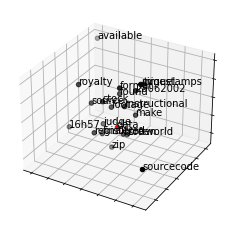

In [15]:
word = "data"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [16]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [17]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  xuanyuan sword vii pc 02112020 1301 supermarket shriek pc 02112020 1257 strategic mind blitzkrieg pc 02112020 1257 positronx pc 02112020 1248 dysmantle pc 02112020 1241 double kick hero pc 02112020 1240 circadian city pc 02112020 1238 cake bash pc 02112020 1237 dark picture anthology little hope pc 02112020 1221 pumpkin jack pc 02112020 12160 1 | len: 55
to:  [461 462 463  11  13 464 465 466  11  13 203 467 468 469  11] | len: 15
check:  xuanyuan  -- idx in vocabulary --> 461
vocabulary:  {'NaN': 1, 'nan': 2, '1': 3, '2': 4, '6': 5} ... (padding element, 0)


In [18]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [19]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [20]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 317 |idx
embeddings[idx]: (300,) |vector


In [28]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(5, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      438300      input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 15)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 15)      240         permute_1[0][0]                  
____________________________________________________________________________________________

In [25]:
X_train.shape

(62, 15)

In [27]:
y_train

array([1, 4, 1, 4, 1, 1, 0, 1, 1, 4, 1, 3, 3, 0, 4, 2, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 4, 1, 4, 2, 2, 2, 1, 1, 3, 1, 1, 2, 1,
       1, 1, 2, 0, 2, 3, 4, 4, 4, 1, 3, 2, 0, 1, 4, 1, 1, 4])

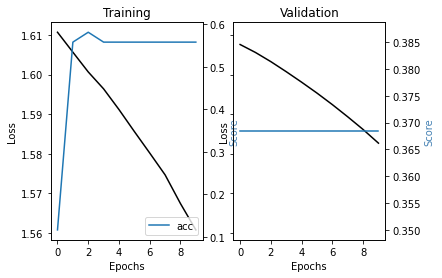

In [29]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


In [30]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

